In [1]:
import os
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import open3d as o3d
from igraph import *
import open3d.t.pipelines.registration as treg
from tqdm.notebook import tqdm
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from scipy.spatial.transform import Rotation
import time
import copy

# Вспомогательные функции

In [3]:
preprocess_time = []
sampling_time = []
graph_construction_time = []
max_clique_time = []
transform_time = []
icp_time = []

In [4]:
def visualize_pcd(ref_cloud, color=False):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ref_cloud[:, :3])
    if color:
        pcd.colors = o3d.utility.Vector3dVector(ref_cloud[:, 3:] / 255)

    o3d.visualization.draw_plotly([pcd], width=800, height=600)


def draw_registration_result(source, target, transformation, title=None):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])

    source_temp.transform(transformation)

    if title is not None:
        print(title)

    o3d.visualization.draw_plotly([source_temp, target_temp])


def compare_grids(grid1, grid2, label1='Current grid', label2='Reference grid'):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    cmap = mpt.colors.ListedColormap(['white', 'gray', 'black'])

    axs[0].imshow(grid1, cmap=cmap)
    axs[0].set_title(label1)
    axs[0].grid(True, alpha=0.5, linestyle='-')

    axs[1].imshow(grid2, cmap=cmap)
    axs[1].set_title(label2)
    axs[1].grid(True, alpha=0.5, linestyle='-')

    fig.tight_layout()
    fig.show()


def visualize_iou(aligned_grid):
    plt.imshow(aligned_grid)
    plt.axis(False)
    plt.grid(True, alpha=0.5, linestyle='-')

    plt.show()


def make_pcd_from_array(array):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(array)

    return pcd

In [5]:
def remove_floor_and_ceil(cloud, floor_height=-0.9, ceil_height=1.5):
    heights = np.linspace(-4.0, 4.0, 41)
    floor_index = None
    if floor_height == 'auto':
        bins = []
        for i, height in enumerate(heights[:-1]):
            bins.append(len(cloud[(cloud[:, 2] > height) * (cloud[:, 2] < heights[i + 1])]))
        #print('Bins:', bins)
        floor_index = np.argmax(bins[:20]) + 1
        floor_height = heights[floor_index]
        assert floor_index < len(heights) - 5
    if ceil_height == 'auto':
        if floor_index is None:
            floor_index = 0
            while floor_index < len(heights) - 6 and heights[floor_index] < floor_height:
                floor_index += 1
        ceil_index = floor_index + 5 + np.argmax(bins[floor_index + 5:])
        ceil_height = heights[ceil_index]
    #print('Floor height:', floor_height)
    #print('Ceil height:', ceil_height)
    return cloud[(cloud[:, 2] > floor_height) * (cloud[:, 2] < ceil_height)]

In [6]:
def raycast(grid, n_rays=1000, center_point=None):
    grid_raycasted = grid.copy()
    if center_point is None:
        center_point = (grid.shape[0] // 2, grid.shape[1] // 2)
    resolution = 0.1
    radius = 8.0 / resolution
    for sector in range(n_rays):
        angle = sector / n_rays * 2 * np.pi - np.pi
        ii = center_point[0] + np.sin(angle) * np.arange(0, radius)
        jj = center_point[1] + np.cos(angle) * np.arange(0, radius)
        ii = ii.astype(int)
        jj = jj.astype(int)
        good_ids = ((ii > 0) * (ii < grid.shape[0]) ** (jj > 0) * (jj < grid.shape[1])).astype(bool)
        ii = ii[good_ids]
        jj = jj[good_ids]
        points_on_ray = grid[ii, jj]
        if len(points_on_ray.nonzero()[0]) > 0:
            last_obst = points_on_ray.nonzero()[0][-1]
            grid_raycasted[ii[:last_obst], jj[:last_obst]] = 1
        #else:
            #grid_raycasted[ii, jj] = 1
    return grid_raycasted

In [7]:
from scipy.ndimage import affine_transform

def transform_grid(grid, x, y, theta):
    shift_vector = np.array([x, y])
    rotation_matrix = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])

    center = np.array(grid.shape) / 2
    offset = center - rotation_matrix @ center
    offset += shift_vector

    grid_transformed = np.zeros(grid.size).reshape(grid.shape)
    grid_transformed = affine_transform(grid, rotation_matrix, offset=offset, order=0, mode='constant', cval=0)
    grid_transformed = grid_transformed.astype(np.uint8)
    return grid_transformed

def transform_pcd(cloud, x, y, theta):
    pcd_transformed = cloud.copy()  # эта функция нигде не вызывается, оставляем так
    return pcd_transformed

In [8]:
def get_occupancy_grid(points_xyz, resolution=0.1, radius=18, clip=8):
    index = np.isnan(points_xyz).any(axis=1)
    
    points_xyz = np.delete(points_xyz, index, axis=0)
    points_xyz = points_xyz[(points_xyz[:, 0] > -clip) * (points_xyz[:, 0] < clip) * \
                            (points_xyz[:, 1] > -clip) * (points_xyz[:, 1] < clip)]
    points_xyz_obstacles = remove_floor_and_ceil(points_xyz, floor_height=-0.3, ceil_height=0.5)

    #print('Points xyz:', points_xyz.shape, points_xyz[0], points_xyz.min(), points_xyz.max())
    grid = np.zeros((int(2 * radius / resolution), int(2 * radius / resolution)), dtype=np.uint8)
    points_ij = np.round(points_xyz[:, :2] / resolution).astype(int) + \
                        [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    
    grid[points_ij[:, 0], points_ij[:, 1]] = 1
    grid = raycast(grid)
    
    points_ij = np.round(points_xyz_obstacles[:, :2] / resolution).astype(int) + \
                [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    
    grid[points_ij[:, 0], points_ij[:, 1]] = 2
    return grid

In [9]:
def get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, visualize, save=False, cnt=0):
    rel_x_rotated = -rel_x * np.cos(rel_theta) - rel_y * np.sin(rel_theta)
    rel_y_rotated = rel_x * np.sin(rel_theta) - rel_y * np.cos(rel_theta)
    rel_x, rel_y = rel_x_rotated, rel_y_rotated
    
    cur_grid_transformed = transform_grid(cur_grid, rel_x, rel_y, rel_theta)
    cur_grid_transformed[cur_grid_transformed > 0] = 1
    
    v_grid_copy = v_grid.copy()
    v_grid_copy[v_grid_copy > 0] = 1
    
    intersection = np.sum(v_grid_copy * cur_grid_transformed)
    union = np.sum(v_grid_copy | cur_grid_transformed)

    grid_aligned = np.zeros((v_grid.shape[0], v_grid.shape[1], 3))
    grid_aligned[:, :, 0] = cur_grid_transformed
    grid_aligned[:, :, 1] = v_grid
    grid_aligned = (grid_aligned * 255).astype(np.uint8)
    
    if visualize:
        visualize_iou(grid_aligned)

    return intersection / union

In [10]:
def get_iou(rel_x, rel_y, rel_theta, cur_cloud, v_cloud, visualize=False):
    cur_grid = get_occupancy_grid(cur_cloud)
    v_grid = get_occupancy_grid(v_cloud)

    try:
        return get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, visualize)
    except ZeroDivisionError:
        return 0
    except Exception as e:
        print(e)
        return 0

In [11]:
def normalize(angle):
    while angle > np.pi:
        angle -= 2 * np.pi
    while angle < -np.pi:
        angle += 2 * np.pi
    return angle

def transformation_error(gt_pose_shift, tf_matrix_estimated):
    tf_rotation = Rotation.from_matrix(tf_matrix_estimated[:3, :3]).as_rotvec()
    gt_x, gt_y, gt_angle = gt_pose_shift
    gt_angle = -gt_angle
    estimated_angle = tf_rotation[2]
    estimated_x = tf_matrix_estimated[0, 3]
    estimated_y = tf_matrix_estimated[1, 3]
    return (np.abs(estimated_x - gt_x), np.abs(estimated_y - gt_y), np.abs(normalize(estimated_angle - gt_angle)))

In [ ]:
def rotate(x, y, angle):
    x_new = x * np.cos(angle) + y * np.sin(angle)
    y_new = -x * np.sin(angle) + y * np.cos(angle)
    return x_new, y_new

def get_rel_pose(x, y, theta, x2, y2, theta2):
    rel_x, rel_y = rotate(x2 - x, y2 - y, theta)
    return [rel_x, rel_y, normalize(theta2 - theta)]

: 

In [13]:
from dataclasses import dataclass, asdict

@dataclass
class RegistrationResult:
    method_name: str
    data_cloud: str
    candidate_idx: int
    iou: float
    dist: float
    fitness: float
    transform: list
    error: list

# FCGF

In [14]:
fcgf_model_path = '../../FCGF/weights/kitti.pth'

In [15]:
from fcgf import ResUNetBN2C as FCGF
from cal_fcgf import extract_features

def extract_fcgf(pcd, voxel_size, model_path):
    fcgf_model = FCGF(
        1,
        32,
        bn_momentum=0.05,
        conv1_kernel_size=7,
        normalize_feature=True
    ).cuda()
    checkpoints = torch.load(model_path)
    # # 3DMatch: http://node2.chrischoy.org/data/projects/DGR/ResUNetBN2C-feat32-3dmatch-v0.05.pth
    # # KITTI: http://node2.chrischoy.org/data/projects/DGR/ResUNetBN2C-feat32-kitti-v0.3.pth
    fcgf_model.load_state_dict(checkpoints['state_dict'])
    fcgf_model.eval()

    xyz_down, features = extract_features(
        fcgf_model,
        xyz=pcd,
        rgb=None,
        normal=None,
        voxel_size=voxel_size,
        skip_check=True,
    )
    return xyz_down.astype(np.float32), features.detach().cpu().numpy()

In [16]:
import sys
sys.path.insert(1, '/home/mavovk/TestTask')

In [17]:
from model import load_model

def get_model(model_path, device):
    checkpoint =  torch.load(model_path, weights_only=False)
    config = checkpoint['config']

    num_feats = 1
    Model = load_model(config.model)

    model = Model(num_feats, config.model_n_out, bn_momentum=0.05, normalize_feature=config.normalize_feature,
                conv1_kernel_size=config.conv1_kernel_size, D=3)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    model = model.to(device)

    return model

# FastMAC

In [18]:
def euclidean(a, b):
    return torch.norm(a - b, dim=-1, keepdim=True)

def compatibility(a,b):
    assert(a.shape[-1]==6)
    assert(b.shape[-1]==6)
    n1=torch.norm(a[...,:3]-b[...,:3],dim=-1,keepdim=True)
    n2=torch.norm(a[...,3:]-b[...,3:],dim=-1,keepdim=True)
    return torch.abs(n1-n2)

def Dmatrix(a,type):
    if type=="euclidean":
        return torch.cdist(a,a)
        
    elif type=="compatibility":
        a1=a[...,:3]
        a2=a[...,3:]
        return torch.abs(Dmatrix(a1,"euclidean")-Dmatrix(a2,"euclidean"))

class GraphConstructor(nn.Module):
    def __init__(self,inlier_thresh,thresh,trainable,device="cuda",sigma=None,tau=None) -> None:
        '''
        inlier thresh: KITTI 0.6, 3dmatch 0.1
        thresh: fpfh 0.9, fcgf 0.999
        '''
        super().__init__()
        self.device=device
        self.inlier_thresh=nn.Parameter(torch.tensor(inlier_thresh,requires_grad=trainable,dtype=torch.float32)).to(device)
        self.thresh=nn.Parameter(torch.tensor(thresh,requires_grad=trainable,dtype=torch.float32)).to(device)
        if sigma is not None:
            self.sigma=nn.Parameter(torch.tensor(sigma,requires_grad=trainable,dtype=torch.float32)).to(device)
        else:
            self.sigma=self.inlier_thresh
        if tau is not None:
            self.tau=nn.Parameter(torch.tensor(tau,requires_grad=trainable,dtype=torch.float32)).to(device)
        else:
            self.tau=self.thresh
    def forward(self,points,mode,k1=1,k2=1):
        '''
        points: B x M x 6
        output: B x M x M
        '''
        if mode=="correspondence":
            points=points.to(self.device)
            dmatrix=Dmatrix(points,"compatibility")
            score=1-dmatrix**2/self.inlier_thresh**2
            # score=torch.exp(-dmatrix**2/self.inlier_thresh**2)
            score[score<self.thresh]=0
            if k1==1:
                return score
            else:
                return score*torch.einsum("bmn,bnk->bmk",score,score)
        elif mode=="pointcloud":
            '''
            points: B x N x 3
            output: B x N x N
            '''
            points=points.to(self.device)
            dmatrix=Dmatrix(points,"euclidean")
            
            # score=1-dmatrix**2/self.inlier_thresh**2
            score=torch.exp(-dmatrix**2/self.sigma**2)
            score[score<self.tau]=0
            if k2==1:
                return score
            else:
                return score*torch.einsum("bmn,bnk->bmk",score,score)

In [19]:
def extract_fpfh_features(pcd, downsample):
    keypts = pcd.voxel_down_sample(downsample)
    keypts.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=downsample * 2, max_nn=30))
    
    features = o3d.pipelines.registration.compute_fpfh_feature(keypts, o3d.geometry.KDTreeSearchParamHybrid(
        radius=downsample * 5, max_nn=100))
    features = np.array(features.data).T
    features = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-6)

    return keypts.points, features

In [20]:
def pcd_sampling(pcd, num_points):
    n = min(pcd.shape[0], num_points)
    idxs = np.arange(0, n)
    np.random.shuffle(idxs)

    return pcd[idxs[:n], :].copy()

In [21]:
def preprocess_MAC(source, target, voxel_size, model=None):
    t1 = time.perf_counter()
    src_pcd = o3d.geometry.PointCloud()
    src_pcd.points = o3d.utility.Vector3dVector(source)

    tgt_pcd = o3d.geometry.PointCloud()
    tgt_pcd.points = o3d.utility.Vector3dVector(target)

    src_kpts, src_desc = extract_fpfh_features(src_pcd, voxel_size)
    tgt_kpts, tgt_desc = extract_fpfh_features(tgt_pcd, voxel_size)
    # src_kpts, src_desc = extract_fcgf(source, voxel_size, model)
    # tgt_kpts, tgt_desc = extract_fcgf(target,voxel_size, model)

    distance = np.sqrt(2 - 2 * (src_desc @ tgt_desc.T) + 1e-6)
    min_vals = np.min(distance, axis=1)
    source_idx = np.argmin(distance, axis=1)
    corr_idx = np.concatenate([np.arange(source_idx.shape[0])[:, None], source_idx[:, None]],
                            axis=-1)

    source_points = torch.from_numpy(np.array(src_kpts)).type(torch.FloatTensor)[corr_idx[:,0]]
    target_points = torch.from_numpy(np.array(tgt_kpts)).type(torch.FloatTensor)[corr_idx[:,1]]
    correspondence_pcd = np.hstack([source_points, target_points])

    preprocess_time.append(time.perf_counter() - t1)
    return source_points, target_points, correspondence_pcd, corr_idx, min_vals

In [22]:
def sample_points(kpts, desc, num_points):
    n = min(num_points, len(kpts))
    idxs = np.arange(0, n)
    np.random.shuffle(idxs)

    return np.asarray(kpts)[idxs[:n], :].copy(), desc[idxs[:n], :].copy()

def get_features(source, target, voxel_size):
    src_pcd = o3d.geometry.PointCloud()
    src_pcd.points = o3d.utility.Vector3dVector(source)

    tgt_pcd = o3d.geometry.PointCloud()
    tgt_pcd.points = o3d.utility.Vector3dVector(target)

    src_kpts, src_desc = extract_fpfh_features(src_pcd, voxel_size)
    tgt_kpts, tgt_desc = extract_fpfh_features(tgt_pcd, voxel_size)

    return src_kpts, src_desc, tgt_kpts, tgt_desc

def sampled_correspondences(src_kpts, src_desc, tgt_kpts, tgt_desc, num_points, sample_ratio):
    t1 = time.perf_counter()
    src_kpts, src_desc = sample_points(src_kpts, src_desc, num_points)
    tgt_kpts, tgt_desc = sample_points(tgt_kpts, tgt_desc, num_points)

    distance = np.sqrt(2 - 2 * (src_desc @ tgt_desc.T) + 1e-6)
    source_idx = np.argmin(distance, axis=1)
    corr_idx = np.concatenate([np.arange(source_idx.shape[0])[:, None], source_idx[:, None]],
                            axis=-1)

    source_points = torch.from_numpy(np.array(src_kpts)).type(torch.FloatTensor)[corr_idx[:,0]]
    target_points = torch.from_numpy(np.array(tgt_kpts)).type(torch.FloatTensor)[corr_idx[:,1]]
    correspondence_pcd = np.hstack([source_points, target_points])

    sampling_time.append(time.perf_counter() - t1)

    return source_points, target_points, correspondence_pcd, corr_idx, None

In [23]:
def graphFilter(points,adjacent_matrix,is_sparse):
    '''
    points: n x 3
    adjacent_matrix: sparse matrix
    
    return:
    score: n x 1
    '''
    if is_sparse:
        xyz=torch.sparse.mm(adjacent_matrix,points)
    else:
        xyz=torch.mm(adjacent_matrix,points)
    return torch.norm(xyz,dim=-1)


def datasample(k,replace,weights):
    '''
    idxs: n
    k: int
    replace: bool
    weights: n
    '''
    try:
        return torch.multinomial(weights,k,replacement=replace)
    except RuntimeError:
        return None


def normalize_scores(x):
    x = x - x.min()
    x = x / x.max()
    return x


def fastmac_sampling(correspondence_pcd, num_points, sample_ratio):
    # t1 = time.perf_counter()

    pts = torch.from_numpy(correspondence_pcd).type(torch.FloatTensor)
    pts = pts.to('cuda')

    grc = GraphConstructor(0.6, 0.999, False, 'cuda', 0.6, 0.)

    corr_graph = grc(pts,mode="correspondence")
    degree_signal = torch.sum(corr_graph,dim=-1)

    corr_laplacian=(torch.diag_embed(degree_signal)-corr_graph).squeeze(0)
    corr_scores=graphFilter(degree_signal.reshape(-1,1),corr_laplacian,is_sparse=False)

    total_scores = normalize_scores(corr_scores)

    k = min(num_points, correspondence_pcd.shape[0])
    k *= sample_ratio
    idxs = datasample(int(k), False, total_scores)

    if idxs is None:
        return None

    # preprocess_time[-1] += time.perf_counter() - t1
    return correspondence_pcd[idxs.cpu()]

In [24]:
def construct_graph(correspondences):
    pts = torch.from_numpy(correspondences).type(torch.FloatTensor)
    pts=pts.to('cuda')

    t1 = time.perf_counter()
    grc = GraphConstructor(0.6, 0.9, False, 'cuda', 0.6, 0.)

    corr_graph = grc(pts, 'correspondence')
    FCG = corr_graph
    FCG = FCG - torch.diag_embed(torch.diag(FCG))
    FCG[FCG < 0.999] = 0
    SCG = torch.matmul(FCG, FCG) * FCG

    graph_construction_time.append(time.perf_counter() - t1)
    return SCG.cpu().detach().numpy()

In [25]:
def find_cliques(TOP_G):
    t1 = time.perf_counter()
    graph = Graph.Adjacency((TOP_G > 0).tolist())
    graph.es['weight'] = TOP_G[TOP_G.nonzero()]
    graph.vs['label'] = range(0, TOP_G.shape[0])
    graph.to_undirected()

    macs = graph.maximal_cliques(min=3)

    max_clique_time.append(time.perf_counter() - t1)
    return macs

In [26]:
def transform(pts, trans):
    if len(pts.shape) == 3:
        trans_pts = torch.einsum('bnm,bmk->bnk', trans[:, :3, :3],
                                 pts.permute(0, 2, 1)) + trans[:, :3, 3:4]
        return trans_pts.permute(0, 2, 1)
    else:
        trans_pts = torch.einsum('nm,mk->nk', trans[:3, :3],
                                 pts.T) + trans[:3, 3:4]
        return trans_pts.T

def integrate_trans(R, t):
    """
    Integrate SE3 transformations from R and t, support torch.Tensor and np.ndarry.
    Input
        - R: [3, 3] or [bs, 3, 3], rotation matrix
        - t: [3, 1] or [bs, 3, 1], translation matrix
    Output
        - trans: [4, 4] or [bs, 4, 4], SE3 transformation matrix
    """
    if len(R.shape) == 3:
        if isinstance(R, torch.Tensor):
            trans = torch.eye(4)[None].repeat(R.shape[0], 1, 1).to(R.device)
        else:
            trans = np.eye(4)[None]
        trans[:, :3, :3] = R
        trans[:, :3, 3:4] = t.view([-1, 3, 1])
    else:
        if isinstance(R, torch.Tensor):
            trans = torch.eye(4).to(R.device)
        else:
            trans = np.eye(4)
        trans[:3, :3] = R
        trans[:3, 3:4] = t
    return trans

def rigid_transform_3d(A, B, weights=None, weight_threshold=0):
    """
    Input:
        - A:       [bs, num_corr, 3], source point cloud
        - B:       [bs, num_corr, 3], target point cloud
        - weights: [bs, num_corr]     weight for each correspondence
        - weight_threshold: float,    clips points with weight below threshold
    Output:
        - R, t
    """
    bs = A.shape[0]
    if weights is None:
        weights = torch.ones_like(A[:, :, 0])
    weights[weights < weight_threshold] = 0
    # weights = weights / (torch.sum(weights, dim=-1, keepdim=True) + 1e-6)

    # find mean of point cloud
    centroid_A = torch.sum(A * weights[:, :, None], dim=1, keepdim=True) / (
            torch.sum(weights, dim=1, keepdim=True)[:, :, None] + 1e-6)
    centroid_B = torch.sum(B * weights[:, :, None], dim=1, keepdim=True) / (
            torch.sum(weights, dim=1, keepdim=True)[:, :, None] + 1e-6)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    # construct weight covariance matrix
    Weight = torch.diag_embed(weights)  # 升维度，然后变为对角阵
    H = Am.permute(0, 2, 1) @ Weight @ Bm  # permute : tensor中的每一块做转置

    # find rotation
    U, S, Vt = torch.svd(H.cpu())
    U, S, Vt = U.to(weights.device), S.to(weights.device), Vt.to(weights.device)
    delta_UV = torch.det(Vt @ U.permute(0, 2, 1))
    eye = torch.eye(3)[None, :, :].repeat(bs, 1, 1).to(A.device)
    eye[:, -1, -1] = delta_UV
    R = Vt @ eye @ U.permute(0, 2, 1)
    t = centroid_B.permute(0, 2, 1) - R @ centroid_A.permute(0, 2, 1)
    # warp_A = transform(A, integrate_trans(R,t))
    # RMSE = torch.sum( (warp_A - B) ** 2, dim=-1).mean()
    return integrate_trans(R, t)

def post_refinement(initial_trans, src_kpts, tgt_kpts, iters, inlier_threshold = 0.1, weights=None):
    pre_inlier_count = 0
    for i in range(iters):
        pred_tgt = transform(src_kpts, initial_trans)
        L2_dis = torch.norm(pred_tgt - tgt_kpts, dim=-1)
        pred_inlier = (L2_dis < inlier_threshold)[0]
        inlier_count = torch.sum(pred_inlier)
        if inlier_count <= pre_inlier_count:
            break
        pre_inlier_count = inlier_count
        initial_trans = rigid_transform_3d(
            A=src_kpts[:, pred_inlier, :],
            B=tgt_kpts[:, pred_inlier, :],
            weights=1 / (1 + (L2_dis / inlier_threshold) ** 2)[:, pred_inlier]
        )
    return initial_trans

In [27]:
def calculate_transform(source_points, target_points, correspondences, TOP_G, macs, inlier_threshold=0.1):
    t1 = time.perf_counter()

    clique_weight = np.zeros(len(macs), dtype=float)
    for ind in range(min(len(macs), 5_000)):
        mac = list(macs[ind])
        if len(mac) >= 3:
            for i in range(min(len(mac), 1_000)):
                for j in range(i + 1, min(len(mac), 1_000)):
                    clique_weight[ind] = clique_weight[ind] + TOP_G[mac[i], mac[j]]

    clique_ind_of_node = np.ones(correspondences.shape[0], dtype=int) * -1
    max_clique_weight = np.zeros(correspondences.shape[0], dtype=float)
    max_size = 3
    for ind in range(min(len(macs), 5_000)):
        mac = list(macs[ind])
        weight = clique_weight[ind]
        if weight > 0:
            for i in range(min(len(mac), 1_000)):
                if weight > max_clique_weight[mac[i]]:
                    max_clique_weight[mac[i]] = weight
                    clique_ind_of_node[mac[i]] = ind
                    max_size = len(mac) > max_size and len(mac) or max_size

    filtered_clique_ind = list(set(clique_ind_of_node))
    try:
        filtered_clique_ind.remove(-1)
    except:
        pass

    group = []
    for _ in range(3, max_size + 1):
        group.append([])
    for ind in filtered_clique_ind:
        mac = list(macs[ind])
        group[len(mac) - 3].append(ind)

    tensor_list_A = []
    tensor_list_B = []
    for i in range(len(group)):
        if len(group[i]) == 0:
            continue
        batch_A = source_points[list(macs[group[i][0]])][None]
        batch_B = target_points[list(macs[group[i][0]])][None]
        if len(group) == 1:
            continue
        for j in range(1, len(group[i])):
            mac = list(macs[group[i][j]])
            src_corr = source_points[mac][None]
            tgt_corr = target_points[mac][None]
            batch_A = torch.cat((batch_A, src_corr), 0)
            batch_B = torch.cat((batch_B, tgt_corr), 0)
        tensor_list_A.append(batch_A)
        tensor_list_B.append(batch_B)

    max_score = 0
    final_trans = torch.eye(4)
    for i in range(len(tensor_list_A)):
        trans = rigid_transform_3d(tensor_list_A[i], tensor_list_B[i], None, 0)
        pred_tgt = transform(source_points[None], trans)  # [bs,  num_corr, 3]
        L2_dis = torch.norm(pred_tgt - target_points[None], dim=-1)  # [bs, num_corr]
        MAE_score = torch.div(torch.sub(inlier_threshold, L2_dis), inlier_threshold)
        MAE_score = torch.sum(MAE_score * (L2_dis < inlier_threshold), dim=-1)
        max_batch_score_ind = MAE_score.argmax(dim=-1)
        max_batch_score = MAE_score[max_batch_score_ind]
        if max_batch_score > max_score:
            max_score = max_batch_score
            final_trans = trans[max_batch_score_ind]


    final_trans1 = post_refinement(final_trans[None], source_points[None], target_points[None], 20, inlier_threshold)

    final_trans = final_trans1[0]
    final_trans = final_trans.cpu().numpy()

    transform_time.append(time.perf_counter() - t1)
    return final_trans

In [28]:
def reset_arrays():
    global preprocess_time
    global graph_construction_time
    global max_clique_time
    global transform_time
    global dists
    global registration_results_fastmac
    global registration_results_icp

    preprocess_time.clear()
    graph_construction_time.clear()
    max_clique_time.clear()
    transform_time.clear()
    dists.clear()
    registration_results_fastmac.clear()
    registration_results_icp.clear()

In [29]:
def fastmac_evaluation(correspondences, num_points, sample_ratio, pbar=None):
    fastmac_correspondences = fastmac_sampling(correspondences, num_points, sample_ratio)

    if fastmac_correspondences is None:
        # preprocess_time.pop()
        return None

    TOP_G = construct_graph(fastmac_correspondences)
    macs = find_cliques(TOP_G)

    if pbar is not None:
        pbar.set_description(f'cliques: {len(macs)}')

    source_fastmac = torch.from_numpy(fastmac_correspondences[:, :3]).type(torch.FloatTensor)
    target_fastmac = torch.from_numpy(fastmac_correspondences[:, 3:]).type(torch.FloatTensor)

    return calculate_transform(source_fastmac, target_fastmac, fastmac_correspondences, TOP_G, macs)

In [30]:
def icp_algorithm(src, tgt, voxel_size, initial):
    source_pcd = make_pcd_from_array(src)
    source_pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=0.4, max_nn=15)
    )

    target_pcd = make_pcd_from_array(tgt)
    target_pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=0.4, max_nn=15)
    )

    source = o3d.t.geometry.PointCloud.from_legacy(source_pcd)
    target = o3d.t.geometry.PointCloud.from_legacy(target_pcd)

    icp_algo = treg.multi_scale_icp(
        source,
        target,
        o3d.utility.DoubleVector([voxel_size]),
        [treg.ICPConvergenceCriteria(relative_fitness=0.0001, relative_rmse=0.0001, max_iteration=5)],
        o3d.utility.DoubleVector([voxel_size * 2]),
        initial,
        treg.TransformationEstimationPointToPlane()
    )

    return icp_algo.transformation.numpy()

# Pipeline

In [31]:
# Change to the actual path to dataset
dataset_dir = '../data'
pr_data_dir = os.path.join(dataset_dir, 'place_recognition_data')
graph_data_dir = os.path.join(dataset_dir, 'graph_data')

np.random.seed(42)

In [32]:
dists = []
registration_results_fastmac = []
registration_results_icp = []

full_iteration_time = []
single_reg = []

In [33]:
data_dir = '../fastmac_data/fastmac'
counter = 0

In [38]:
num_points = 10_000
sample_ratio = 0.01
fitness_threshold = 0.8

In [35]:
import gc

In [39]:
reset_arrays()

In [ ]:
for ii, test_name in (pbar := tqdm(list(enumerate(os.listdir(pr_data_dir))))):
    test_dir = os.path.join(pr_data_dir, test_name)
    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]

    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

    if transforms_.size == 0:
        pass

    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]

    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))

    for i in range(transforms_.size // 7):
        start_iter = time.perf_counter()
        idx = transforms_[i, 0]
        gt_pose = cand_poses[int(idx)]

        # Candidate cloud (from graph of locations)
        cloud = cand_clouds[idx][:, :3]
        cloud = cloud[cloud == cloud].reshape((-1, 3))

        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)

        dist = np.sqrt(pose_shift[0] ** 2 + pose_shift[1] ** 2)
        iou = get_iou(*pose_shift, ref_cloud, cloud, visualize=False)

        ref_pcd = make_pcd_from_array(ref_cloud)
        cloud_pcd = make_pcd_from_array(cloud)

        voxel_size = 0.15

        t1 = time.perf_counter()
        best_eval = None
        best_er = None

        # ============================ #
        source_floor_ceil = remove_floor_and_ceil(ref_cloud)
        target_floor_ceil = remove_floor_and_ceil(cloud)
        # ============================ #

        source_floor_ceil = pcd_sampling(source_floor_ceil, 25_000)
        target_floor_ceil = pcd_sampling(target_floor_ceil, 25_000)

        src_kpts, src_desc, tgt_kpts, tgt_desc = get_features(source_floor_ceil, target_floor_ceil, voxel_size)

        preprocess_time.append(time.perf_counter() - t1)

        # FASTMAC
        # for _ in range(1):
        _, _, correspondences, _, _ = sampled_correspondences(src_kpts, src_desc, tgt_kpts, tgt_desc, num_points, sample_ratio)
        transformation_matrix = fastmac_evaluation(correspondences, num_points, sample_ratio, None)

        if transformation_matrix is None:
            transformation_matrix = np.eye(4)

        # transformation_matrix_inv = np.linalg.inv(transformation_matrix)

        # er = transformation_error(pose_shift, transformation_matrix_inv)
        evaluation = o3d.pipelines.registration.evaluate_registration(ref_pcd, cloud_pcd, 0.4, transformation_matrix)

        # if best_eval is None or best_eval[0] < evaluation.fitness:
        #     best_eval = (evaluation.fitness, transformation_matrix.copy())
            # best_er = er

            # if best_eval[0] > fitness_threshold:
            #     break

        # t1 = time.perf_counter()

        # icp_matrix = icp_algorithm(ref_cloud, cloud, voxel_size, best_eval[1])
        # transformation_matrix_inv = np.linalg.inv(icp_matrix)
        transformation_matrix_inv = transformation_matrix

        # icp_time.append(time.perf_counter() - t1)
    
        error_icp = transformation_error(pose_shift, transformation_matrix_inv)
        evaluation = o3d.pipelines.registration.evaluate_registration(ref_pcd, cloud_pcd, 0.4, transformation_matrix)

        registration_results_fastmac.append(
            RegistrationResult(
                method_name='fastmac_icp',
                data_cloud=test_name,
                candidate_idx=i,
                iou=float(iou),
                dist=float(dist),
                fitness=float(evaluation.fitness),
                transform=list([list(el) for el in transformation_matrix_inv.astype(float)]),
                error=list(error_icp)
            )
        )

        full_iteration_time.append(time.perf_counter() - start_iter)


    if ii % 10 == 0:
        gc.collect()

  0%|          | 0/1648 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [38]:
import json

def save_results(filename, arr):
    data_to_save = [asdict(el) for el in arr]
    with open(f'{filename}.json', 'w') as file:
        json.dump(data_to_save, file)


def load_results(filename):
    with open(f'{filename}.json', 'r') as file:
        return [RegistrationResult(**x) for x in json.load(file)]

In [39]:
save_results('fastmac_single_icp', registration_results_fastmac)

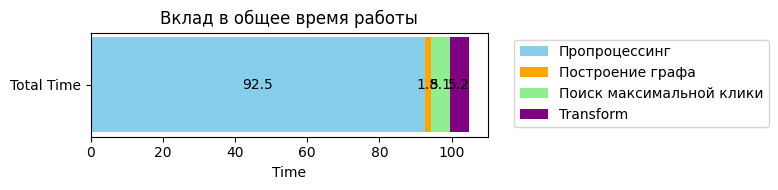

In [42]:
mean_times = [np.mean(preprocess_time) * 1000, np.mean(graph_construction_time) * 1000, np.mean(max_clique_time) * 1000, np.mean(transform_time) * 1000]
labels = ['Пропроцессинг', 'Построение графа', 'Поиск максимальной клики', 'Transform']

total_time = sum(mean_times)

plt.figure(figsize=(8, 2))
bar_height = 0.8

plt.barh(['Total Time'], [mean_times[0]], height=bar_height, label=labels[0], color='skyblue')
plt.barh(['Total Time'], [mean_times[1]], height=bar_height, left=[mean_times[0]], label=labels[1], color='orange')
plt.barh(['Total Time'], [mean_times[2]], height=bar_height, left=[mean_times[0] + mean_times[1]], label=labels[2], color='lightgreen')
plt.barh(['Total Time'], [mean_times[3]], height=bar_height, left=[mean_times[0] + mean_times[1] + mean_times[2]], label=labels[3], color='purple')

for i, time in enumerate(mean_times):
    x_position = sum(mean_times[:i]) + time / 2
    plt.text(x_position, 0, f'{time:.1f}', ha='center', va='center', color='black', fontsize=10)

plt.xlabel('Time')
plt.title('Вклад в общее время работы')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [40]:
print(f'Mean preprocess time: {(np.mean(preprocess_time) * 1000):.2f}')
print(f'Mean sampling time: {(np.mean(sampling_time) * 1000):.2f}')
print(f'Mean graph construction time: {(np.mean(graph_construction_time) * 1000):.2f}')
print(f'Mean max clique time: {(np.mean(max_clique_time) * 1000):.2f}')
print(f'Mean transform time: {(np.mean(transform_time) * 1000):.2f}')
print(f'Mean icp time: {(np.mean(icp_time) * 1000):.2f}')

Mean preprocess time: 92.52
Mean sampling time: 75.01
Mean graph construction time: 1.82
Mean max clique time: 5.14
Mean transform time: 5.22
Mean icp time: 161.78


In [41]:
print(f'Mean iteration time: {(np.mean(full_iteration_time) * 1000):.2f}')
# print(f'Mean signle iteration time: {(np.mean(single_reg) * 1000):.2f}')

Mean iteration time: 589.99


In [44]:
(np.mean(preprocess_time) + np.mean(graph_construction_time) + np.mean(max_clique_time) + np.mean(transform_time)) * 1000

40.220835535801584

In [34]:
threshold = 0.7
print('Precision:', np.sum([(fitness > threshold) * (max(error) < 0.5) \
                                              for fitness, error in icp_results]) / \
                    np.sum([(fitness > threshold) for fitness, error in icp_results]))
print('Recall with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(icp_results)) if ious[i] > 0.5]) / \
                                sum([i > 0.5 for i in ious]))
print('Recall with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(icp_results)) if ious[i] > 0.25]) / \
                                sum([i > 0.25 for i in ious]))

Precision: 0.1309462915601023
Recall with IoU > 0.5: 0.30673316708229426
Recall with IoU > 0.25: 0.05689424364123159


In [42]:
pos = 0
errors = []
transforms = []

for root, dirs, files in os.walk(data_dir):
    if 'trans.txt' in files:
        trans_file_path = os.path.join(root, 'trans.txt')
        transforms.append(
            np.loadtxt(trans_file_path)
        )

In [55]:
for ii, test_name in tqdm(list(enumerate(os.listdir(pr_data_dir)))):
    test_dir = os.path.join(pr_data_dir, test_name)
    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]

    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

    if transforms_.size == 0:
        pass

    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]

    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))

    for i in range(transforms_.size // 7):
        if pos >= len(transforms):
            break

        if np.linalg.det(transforms[pos]) == 0:
            pos += 1
            continue

        idx = transforms_[i, 0]
        gt_pose = cand_poses[int(idx)]
        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)
        iou = get_iou(*pose_shift, ref_cloud, cloud, visualize=False)

        er = transformation_error(pose_shift, np.linalg.inv(transforms[pos]))
        errors.append([iou, er])
        pos += 1

  0%|          | 0/1648 [00:00<?, ?it/s]

/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710495413820100000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710506453259492000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710504397952582000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710505116224765000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_

In [56]:
sum([(max(el[1]) < 0.5) for el in errors])

0

In [ ]:
threshold = 0.7
# print('Precision:', np.sum([(fitness > threshold) * (max(error) < 0.5) \
#                                               for fitness, error in icp_results]) / \
#                     np.sum([(fitness > threshold) for fitness, error in icp_results]))
print('Recall with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(155) if ious[i] > 0.5]) / \
                                sum([i > 0.5 for i in ious]))
print('Recall with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(155) if ious[i] > 0.25]) / \
                                sum([i > 0.25 for i in ious]))

In [40]:
def calc_precision_recall_f1(results, threshold):
    precision = np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) \
                                                for el in results]) / \
                        np.sum([(el.fitness > threshold) for el in results])
    recall = np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) \
                                                for el in results]) / \
                        np.sum([el.iou > 0.5 for el in results])
    f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1

def print_precision_recall(results, method, threshold):
    precision, recall, f1 = calc_precision_recall_f1(results, threshold)

    print(f'Precision {method}: {precision:.3f}')
    print(f'Recall {method}: {recall:.3f}', )
    print(F'F1 score {method}: {f1:.3f}')

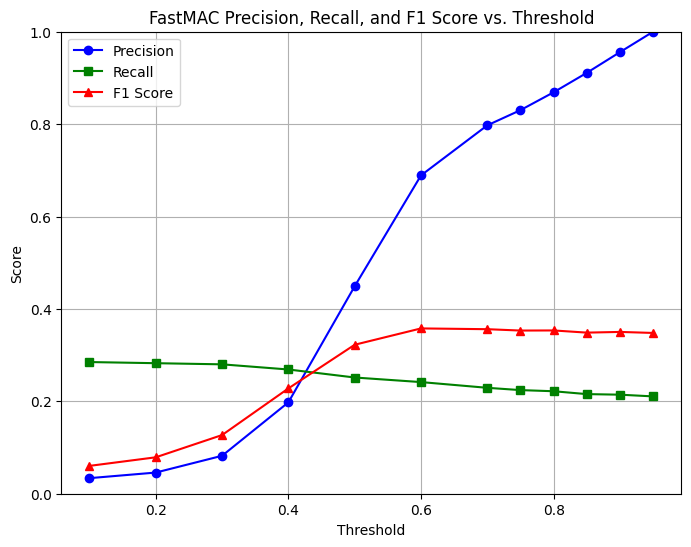

In [42]:
precisions = []
recalls = []
f1s = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    precision, recall, f1 = calc_precision_recall_f1(registration_results_fastmac, threshold)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, marker='o', label='Precision', color='blue')
plt.plot(thresholds, recalls, marker='s', label='Recall', color='green')
plt.plot(thresholds, f1s, marker='^', label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('FastMAC Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [43]:
print_precision_recall(registration_results_fastmac, 'FastMAC', 0.6)

Precision FastMAC: 0.689
Recall FastMAC: 0.242
F1 score FastMAC: 0.358


In [ ]:
# def calculate_fitness(src, tgt, transformation):
#     fitness_score = 0.0

#     src.transform(transformation)

#     # std::vector<int> nn_indices (1);
#     # std::vector<float> nn_dists (1);
#     pcd_tree = o3d.geometry.KDTreeFlann(src)

#     nr = 0
#     for i in range(len(src)):
#         [k, idx, _] = pcd_tree.search_knn_vector_3d(src.points[i], 1)

#         dist

#     # for (size_t i = 0; i < input_transformed.points.size (); ++i)
#     # {
#     #     // Find its nearest neighbor in the target
#     #     tree_->nearestKSearch (src.points[i], 1, nn_indices, nn_dists);

#     #     // Deal with occlusions (incomplete targets)
#     #     if (nn_dists[0] <= max_range)
#     #     {
#     #     // Add to the fitness score
#     #     fitness_score += nn_dists[0];
#     #     nr++;
#     #     } 
#     # } 

#     if nr > 0:
#         return fitness_score / nr
#     else:
#         return float('inf')